In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import json

In [2]:
def approx_eq(a, b):
    return abs(a - b) < .0001

In [3]:
class EulerCauchy:
    def __init__(self, coefficients=np.zeros(3)):
        self.coefficients = coefficients
    
    def m(self): # homogenous solution:
        m_poly = np.poly1d(0)
        for i, coefficient in enumerate(self.coefficients):
            poly = 1
            for i in range(0,len(self.coefficients)-1-i):
                poly *= np.poly1d([1,-i])
            m_poly += poly * coefficient
        return np.roots(m_poly)
        
    def roots(self):
        roots = {} # elements in form of {"m":i} where i is the number of repetitions of the root
        m_vals = self.m()
        for m_val in m_vals:
            matches = [root for root in roots.keys() if approx_eq(root, m_val) or approx_eq(root, np.conjugate(m_val))]
            if matches:
                roots[matches[0]] += 1
            else:
                roots[m_val] = 1
        return roots

    def y(self, x):
        y = 0
        i = 0
        roots = self.roots()
        for root in roots.keys():
            if root.imag:
                for n_rep in range(0, roots[root], 2):
                    y += (math.log(x) ** n_rep) * (x ** root.real) * (self.constants[i] * math.cos(root.imag * math.log(x)) 
                                                                      + self.constants[i+1] * math.sin(root.imag * math.log(x)))
                i += 2
            else:
                for n_rep in range(roots[root]):
                    y += self.constants[i] * (math.log(x) ** n_rep) * (x ** root)
                i += 1
        return float(y)

class ConstantCoefficients:
    def __init__(self, coefficients=np.zeros(3)):
        self.coefficients = coefficients

    def lbda(self):
        return np.roots(self.coefficients)
        
    def roots(self):
        roots = {} # elements in form of {"m":i} where i is the number of repetitions of the root
        lbda_vals = self.lbda()
        for lbda_val in lbda_vals:
            matches = [root for root in roots.keys() if approx_eq(root, lbda_val) or approx_eq(root, np.conjugate(lbda_val))]
            if matches:
                roots[matches[0]] += 1
            else:
                roots[lbda_val] = 1
        return roots
    
    def y(self, x):
        y = 0
        i = 0
        roots = self.roots()
        for root in roots.keys():
            if root.imag:
                for n_rep in range(0, roots[root], 2):
                    y += (x ** n_rep) * (math.e ** (root.real * x)) * (self.constants[i] * math.cos(root.imag * x) 
                                                                      + self.constants[i+1] * math.sin(root.imag * x))
                i += 2
            else:
                for n_rep in range(roots[root]):
                    y += self.constants[i] * (x ** n_rep) * (math.e ** (root.real * x))
                i += 1
        return float(y)

In [4]:
def normalize(values):
    return values - np.min(values) / (np.max(values) - np.min(values)) * 255

def valuemap(i, coefficients, untruncated_constants):
    eq = EulerCauchy(coefficients) if i else ConstantCoefficients(coefficients)
    eq.constants = untruncated_constants
    return np.array(list(map(eq.y, np.arange(1,181))))

In [5]:
from PIL import Image
image = np.asarray(Image.open('test2_bw.jpeg'), dtype=float)[:,:,0]

In [6]:
def generate_image(x_constants, y_constants):
    x_values = sum(valuemap(x_constant['type'], x_constant['coefficients'], x_constant['constants']) for x_constant in x_constants)
    y_values = sum(valuemap(y_constant['type'], y_constant['coefficients'], y_constant['constants']) for y_constant in y_constants)
    x_values = (x_values - np.min(x_values)) / (np.max(x_values) - np.min(x_values)) * 255
    y_values = (y_values - np.min(y_values)) / (np.max(y_values) - np.min(y_values)) * 255
    x_values = np.repeat(x_values[:,np.newaxis], 180, axis=1).T
    y_values = np.repeat(y_values[np.newaxis,:], 180, axis=0).T
    return (x_values + y_values) / 2

In [7]:
def flatten(xss):
    return [x for xs in xss for x in xs]

[[253.3449691  232.82249398 222.14172981 ... 125.93000671 125.88641763
  125.8449691 ]
 [255.         234.47752488 223.79676071 ... 127.58503761 127.54144853
  127.5       ]
 [253.74014882 233.2176737  222.53690953 ... 126.32518643 126.28159735
  126.24014882]
 ...
 [130.25040536 109.72793024  99.04716607 ...   2.83544297   2.79185389
    2.75040536]
 [130.38205716 109.85958205  99.17881788 ...   2.96709478   2.92350569
    2.88205716]
 [130.51621349 109.99373838  99.31297421 ...   3.1012511    3.05766202
    3.01621349]]


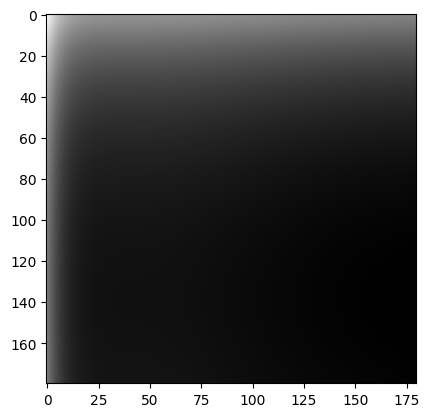

In [8]:
x_constants = [
    {
        'type': 1,
        'coefficients': np.random.rand(3) * 10,
        'constants': np.random.rand(3),
    } for _ in range(5)
]
y_constants = [
    {
        'type': 1,
        'coefficients': np.random.rand(3) * 10,
        'constants': np.random.rand(3),
    } for _ in range(5)
]

generated_image = generate_image(x_constants,y_constants)
print(generated_image)
plt.imshow(generated_image, cmap='gray')

In [9]:
accuracies = {}

while True:
    x_constants = [
        {
            'type': 1,
            'coefficients': np.random.rand(3),
            'constants': np.random.rand(3),
        } for _ in range(5)
    ]
    y_constants = [
        {
            'type': 1,
            'coefficients': np.random.rand(3),
            'constants': np.random.rand(3),
        } for _ in range(5)
    ]

    generated_image = generate_image(x_constants,y_constants)
    mse = np.sum((image - generated_image) ** 2)

    accuracies[mse] = (x_constants, y_constants)
    accuracies = dict(sorted(accuracies.items()))
    plt.imsave('output.jpeg', generated_image, cmap='gray')
    print(list(accuracies.keys())[0])
    
    # combined_x_constants = flatten([constant[0] for constant in lowest_mse.values()])
    # combined_y_constants = flatten([constant[1] for constant in lowest_mse.values()])
    # combined_image = generate_image(combined_x_constants, combined_y_constants)
    # combined_mse = np.sum((combined_image-image) ** 2)

    # if combined_mse in lowest_mse.keys():
    #     continue

    # for key in lowest_mse.keys():
    #     if combined_mse < key:
    #         lowest_mse.popitem()
    #         lowest_mse[combined_mse] = (combined_x_constants, combined_y_constants)
    #         lowest_mse = dict(sorted(lowest_mse.items()))
    #         print(lowest_mse.keys())
    #         break

288078698.4397987
148129701.73827404
148129701.73827404
66499215.97890464
49101867.09986417
49101867.09986417
49101867.09986417
49101867.09986417
49101867.09986417
49101867.09986417
49101867.09986417
49101867.09986417
49101867.09986417
45891329.57559292
45891329.57559292
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872.42327893
42908872

KeyboardInterrupt: 

50.34788330811086


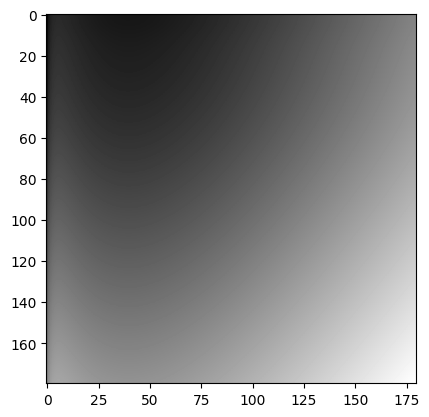

In [10]:
eq = list(accuracies.values())[0]
print(np.std(generate_image(eq[0], eq[1])))
plt.imshow(generate_image(eq[0], eq[1]), cmap='gray')

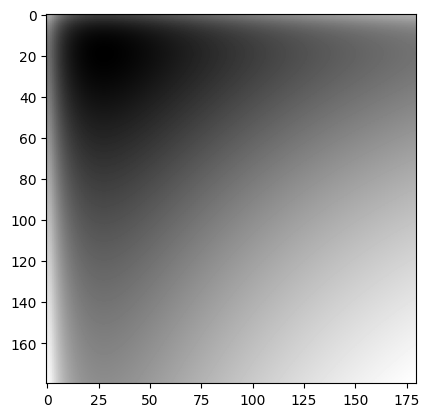

In [11]:
random_images = list(accuracies.values())[0:50]
# combined_x_constants = flatten([constant[0] for constant in lowest_mse.values()])
# combined_y_constants = flatten([constant[1] for constant in lowest_mse.values()])
combined_image = np.zeros((180,180))
for im in random_images:
    combined_image += generate_image(im[0], im[1])
combined_image /= len(random_images)
combined_mse = np.sum((combined_image-image) ** 2)
plt.imshow(combined_image, cmap='gray')